In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y), timesteps, 1), np.array(y).reshape(len(y), 1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        epsilon = 1e-2
        self.Wx = np.random.randn(x.shape[2], hidden_units) * epsilon# shape (hidden units, number of input features)
        self.Wh = np.random.randn(hidden_units,hidden_units)* epsilon #shape (hidden units, hidden units)
        self.Wy = np.random.randn(hidden_units, y.shape[1]) * epsilon#shape ( number of output features,hidden units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(xt, self.Wx) + np.dot(ht_1, self.Wh)) #ht=tanh(Wx*x + Wh*h_t-1)
        yt = np.dot(ht, self.Wy) # yt=Wy*ht

        return ht, yt
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((1, self.hidden_units))   # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step].reshape(1,1), ht) # call cell definition to give ht, yt
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
            # use append to store all ht inside hidden_states 
        self.error = np.subtract(yt, sample_y)   #yt - true value of y
        self.loss = 0.5*np.sum(np.square(self.error)) # #0.5*(yt - true value of y)**2
        self.yt = yt

    
    def backward(self):
        n = len(self.inputs) # number of terms present
        dyt =  self.error # dL/dyt
        dWy =  np.dot(self.hidden_states[-1].T, dyt) # dL/dWy
        dht =  np.dot(dyt, self.Wy.T)    # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx =  np.zeros_like(self.Wx)    # inialise zeros of shape dWx
        dWh =  np.zeros_like(self.Wh)    # inialise zeros of shape dWy
        # BPTT
        for step in reversed(range(n)):
            temp =  ( 1 - np.square(self.hidden_states[step])) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx +=  np.dot(  self.inputs[step].T, temp)               # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh +=  np.dot(  self.hidden_states[step-1].T, temp)      # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht =  np.dot(temp, self.Wh.T) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh   # updation of dht 
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs) , total = epochs):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            epoch_loss = np.squeeze(self.loss / self.x.shape[0])
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            self.loss = 0
        print('Epoch: {}, Loss: {}'.format(epoch, epoch_loss))
            
        
        
    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        
x,y = dataset()

x_test, y_test = dataset(300)
x_test = x_test[250:]
y_test = y_test[250:]
rnn = RNN(x,y,100)
rnn.train(50,1e-2)
rnn.test(x_test, y_test)


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

Epoch: 49, Loss: 1.4054483699224563e-07


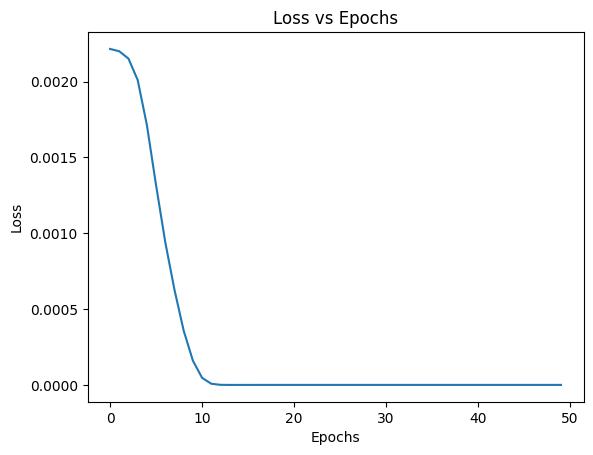

In [6]:
plt.plot(rnn.Ovr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

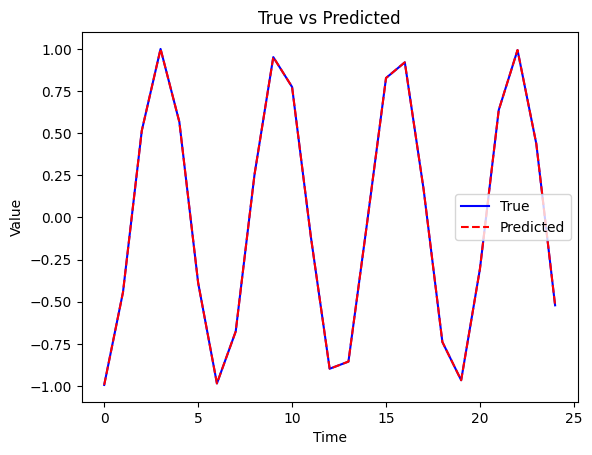

In [11]:
plt.plot(y_test, label = 'True',  color = 'blue')
plt.plot(rnn.y, label = 'Predicted', color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.show()